/usr/lib/python3/dist-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/usr/lib/python3/dist-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu


            date    price   returns  absreturn  survival
9486  1987-10-30  2722.32 -0.411547   0.411547  0.016393
8687  1990-08-17  4010.00 -0.305355   0.305355  0.032787
8653  1990-10-02  2593.00 -0.296226   0.296226  0.049180
8755  1990-05-24  6587.00 -0.255203   0.255203  0.065574
5593  2001-09-25  3493.78 -0.223408   0.223408  0.081967
Taiwan stock index N 915 MS 0.22
             date   price   returns  absreturn  survival
7854   1987-10-23  248.22 -0.259708   0.259708  0.012987
2567   2008-10-10  899.22 -0.251531   0.251531  0.025974
2465   2009-03-10  719.60 -0.148964   0.148964  0.038961
14229  1962-06-13   55.50 -0.139684   0.139684  0.051948
17221  1950-07-17   16.68 -0.130229   0.130229  0.064935
S&P500 stock index N 1020 MS 0.57
Gaussian with same σ as TAIEX mean 0.000347 stdev 0.014374
Gaussian with same σ as TAIEX N 915 MS 0.05


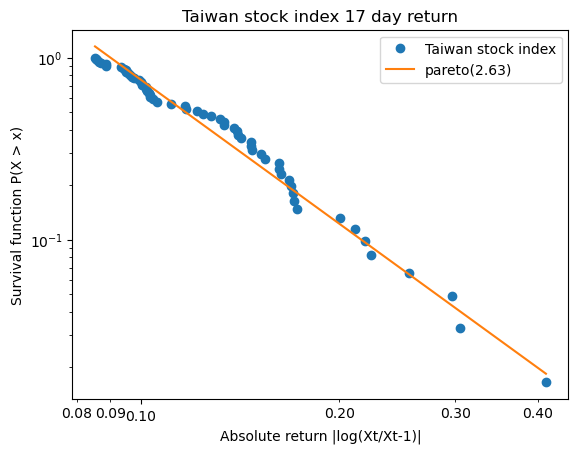

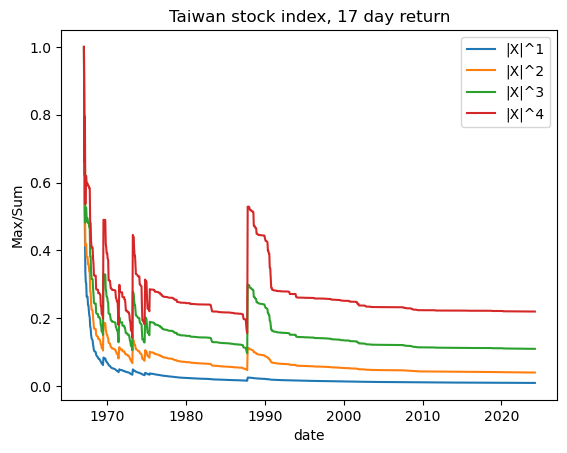

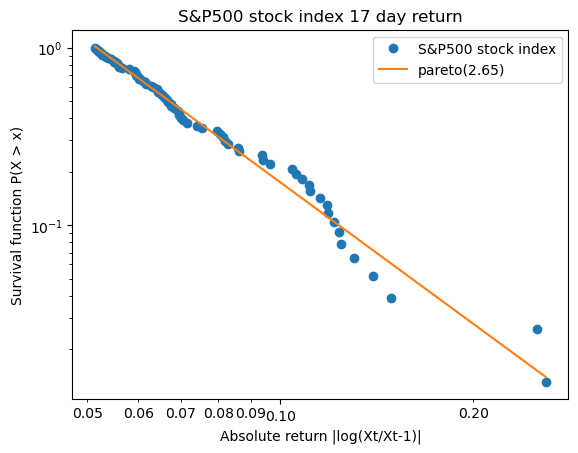

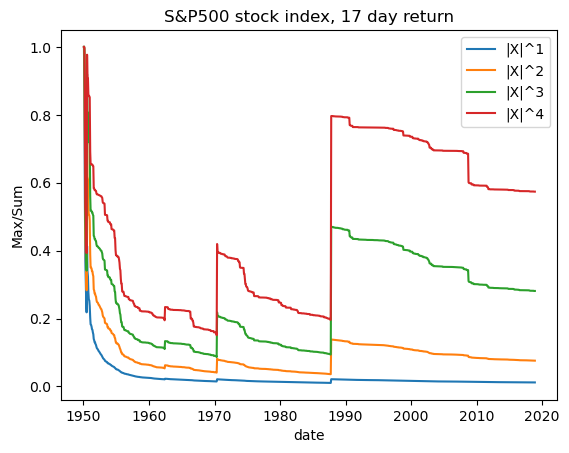

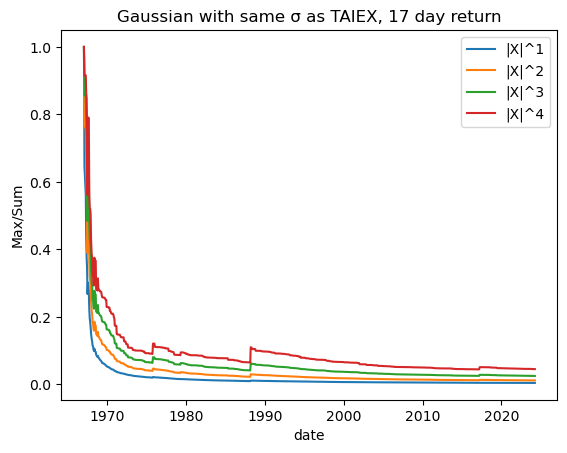

In [1]:
import sys

import numpy as np
import pandas
import scipy
import scipy.stats
import statsmodels
import statsmodels.tsa
import statsmodels.tsa.stattools
import matplotlib
import matplotlib.pyplot as plt


class Analysis:
    def __init__(self):
        self.name = ""
        self.fpath = ""

        self.lag = 1
        self.tailCutoff = 0.001


def tailLinReg(x, y):
    # Sort data.
    data = np.stack([x, y], axis=1)
    data = data[data[:, 0].argsort()]

    # Give more weight to tail.
    last = data[len(data)-1]
    for i in range(int(data.shape[0]*0.1)):
        data = np.append(data, [last], axis=0)

    lr = scipy.stats.linregress(data[:, 0], data[:, 1])
    return lr


def analyzePareto(analysis):
    df = pandas.read_csv(analysis.fpath, dtype={'price': np.float64})
    
    # df["returns"] = df.price / df.price.shift(-analysis.lag)-1
    # df.drop(df.tail(analysis.lag).index,inplace=True)
    df = df.iloc[::analysis.lag, :]
    df["returns"] = df.price / df.price.shift(-1)-1
    df["returns"] = np.log(df.price / df.price.shift(-1))
    df.drop(df.tail(1).index,inplace=True)

    df["absreturn"] = df.returns.apply(lambda x: np.abs(x))
    df = df[df.returns < 0]
    df = df[(df.absreturn > analysis.lag*analysis.tailCutoff)]
    if len(df) == 0:
        return
    
    df = df.sort_values(by='absreturn', ascending=False)
    df["survival"] = 1-(df.absreturn.rank()-1) / len(df)
    
    # Maximum likelihood method. 
    xm = np.min(df.absreturn)
    alpha = len(df)/np.sum(np.log(df.absreturn/xm))

    # Linear regression method.
    lr = tailLinReg(np.log(df.absreturn), np.log(df.survival))
    alpha = -lr.slope
    xm = np.power(np.exp(lr.intercept), 1/alpha)

    # Scipy method.
    scipyPareto = scipy.stats.pareto.fit(df.absreturn, scale=analysis.lag*0.02)
    scipyAlpha = scipyPareto[0]

    fitted = np.power(xm/df.absreturn, alpha)
    
    print(df.head(5))
    fig, ax = plt.subplots(1, 1)
    ax.plot(df.absreturn.to_numpy(), df.survival.to_numpy(), "o", label=analysis.name)
    ax.plot(df.absreturn.to_numpy(), fitted.to_numpy(), label=("pareto(%.2f)"%(alpha)))
    ax.legend()
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: '%.2f' % x))
    ax.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: '%.2f' % x))
    ax.set_title("%s %d day return" % (analysis.name, analysis.lag))
    ax.set_xlabel("Absolute return |log(Xt/Xt-1)|")
    ax.set_ylabel("Survival function P(X > x)")
    # fig.savefig("loglog_%s"%analysis.name)


def analyzeMSp(df, p):
    df["Xp%d" % p] = np.power(df.absreturn, p)

    df["msMax%d" % p] = df["Xp%d" % p].cummax()
    if False:
        k = 10
        for i in range(len(df)):
            subset = df.iloc[:i+1]
            vs = subset["Xp%d" % p].to_numpy().copy()
    
            vs = np.sort(vs)
            largest = vs[max(0, len(vs)-k):]
            mx = np.sum(largest)
    
            df.iloc[i, df.columns.get_loc("msMax%d" % p)] = mx
            
    
    df["msSum%d" % p] = df["Xp%d" % p].cumsum()
    df["ms%d" % p] = df["msMax%d" % p] / df["msSum%d" % p]


def plotMS(analysis, df):
    fig, ax = plt.subplots(1, 1)
    for p in [1, 2, 3, 4]:
        analyzeMSp(df, p)
        x = matplotlib.dates.date2num(df.date)
        y = df["ms%d" % p].to_numpy()
        x = x[0:]
        y = y[0:]
        ax.plot_date(x, y, fmt="-", label=("|X|^%d" % p))
    ax.legend()
    ax.set_title("%s, %d day return" % (analysis.name, analysis.lag))
    ax.set_xlabel("date")
    ax.set_ylabel("Max/Sum")
    # fig.savefig("ms_%s"%analysis.name)
    print("%s N %d MS %.2f" % (analysis.name, len(df), df.iloc[len(df)-1]["ms4"]))


def analyzeMS(analysis):
    df = pandas.read_csv(analysis.fpath, dtype={'price': np.float64})
    df = df.sort_values(by='date', ascending=True)
    df = df.iloc[::analysis.lag, :]
    df["returns"] = np.log(df.price / df.price.shift(1))
    df.drop(df.head(1).index,inplace=True)
    df["absreturn"] = df.returns.apply(lambda x: np.abs(x))

    plotMS(analysis, df)
    #df.to_csv("qqq.csv")


def analyze(analysis):
    analyzePareto(analysis)
    analyzeMS(analysis)


# Plot a MS-plot for a normal distribution corresponding to TAIEX.
def ms_taiex_gaussian(lag):
    analysis = Analysis()
    analysis.name = "Gaussian with same σ as TAIEX"
    analysis.lag = lag
    
    # Compute daily standard deviation
    df = pandas.read_csv("taiex.csv", dtype={'price': np.float64})
    df["returns"] = np.log(df.price / df.price.shift(-1))
    df.drop(df.tail(1).index,inplace=True)
    mean = np.mean(df.returns)
    std = np.std(df.returns)
    print("%s mean %f stdev %f" % (analysis.name, mean, std))
    
    # Simulate a normal distribution using the computed standard deviation.
    df = pandas.read_csv("taiex.csv", dtype={'price': np.float64})
    df = df.sort_values(by='date', ascending=True)
    df["returns"] = np.random.normal(loc=0, scale=std, size=len(df))
    for i in range(len(df)):
        if i == 0:
            continue
        lastPrice = df.iloc[i-1].price
        returnI = np.exp(df.iloc[i].returns)
        df.iloc[i, df.columns.get_loc("price")] = lastPrice*returnI

    df = df.iloc[::analysis.lag, :]
    df["returns"] = np.log(df.price / df.price.shift(1))
    df.drop(df.head(1).index,inplace=True)
    df["absreturn"] = df.returns.apply(lambda x: np.abs(x))
    plotMS(analysis, df)


analysisLag = 17
for lag in [analysisLag]:
    for tailCutoff in [0.005]:
        analysis = Analysis()
        analysis.name = "Taiwan stock index"
        analysis.fpath = "taiex.csv"
        analysis.lag = lag
        analysis.tailCutoff = tailCutoff
        analyze(analysis)
        
        analysis.name = "S&P500 stock index"
        analysis.fpath = "sp500.csv"
        analysis.tailCutoff = 0.003
        analyze(analysis)
ms_taiex_gaussian(analysisLag)

gaussian variance: 1.000000
gaussian run 0
gaussian run 100
gaussian run 200
gaussian run 300
gaussian run 400
gaussian run 500
gaussian run 600
gaussian run 700
gaussian run 800
gaussian run 900
gaussian run 1000
gaussian run 1100
gaussian run 1200
gaussian run 1300
gaussian run 1400
gaussian run 1500
gaussian run 1600
gaussian run 1700
gaussian run 1800
gaussian run 1900
gaussian run 2000
gaussian run 2100
gaussian run 2200
gaussian run 2300
gaussian run 2400
gaussian run 2500
gaussian run 2600
gaussian run 2700
gaussian run 2800
gaussian run 2900
gaussian run 3000
gaussian run 3100
gaussian run 3200
gaussian run 3300
gaussian run 3400
gaussian run 3500
gaussian run 3600
gaussian run 3700
gaussian run 3800
gaussian run 3900
gaussian run 4000
gaussian run 4100
gaussian run 4200
gaussian run 4300
gaussian run 4400
gaussian run 4500
gaussian run 4600
gaussian run 4700
gaussian run 4800
gaussian run 4900
gaussian run 5000
gaussian run 5100
gaussian run 5200
gaussian run 5300
gaussian run

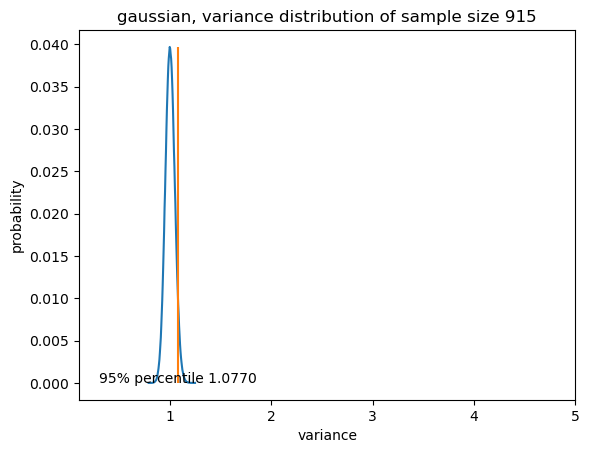

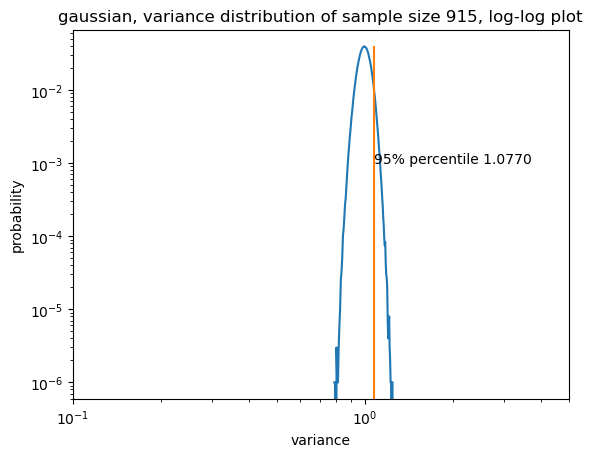

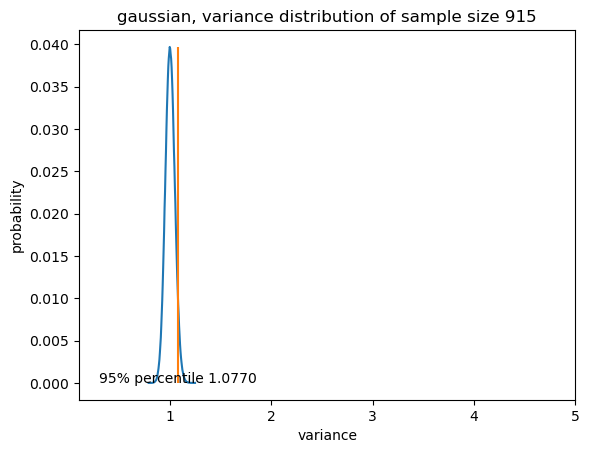

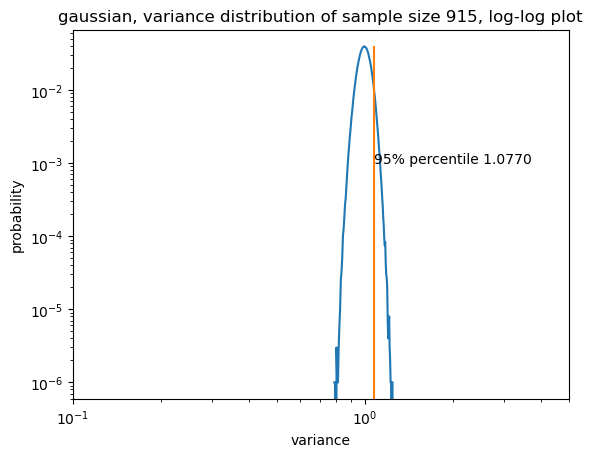

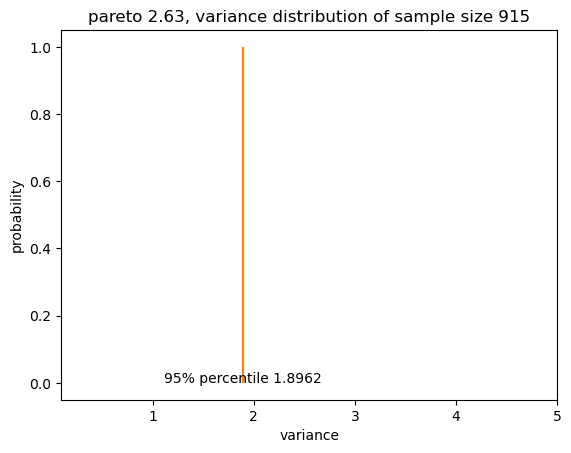

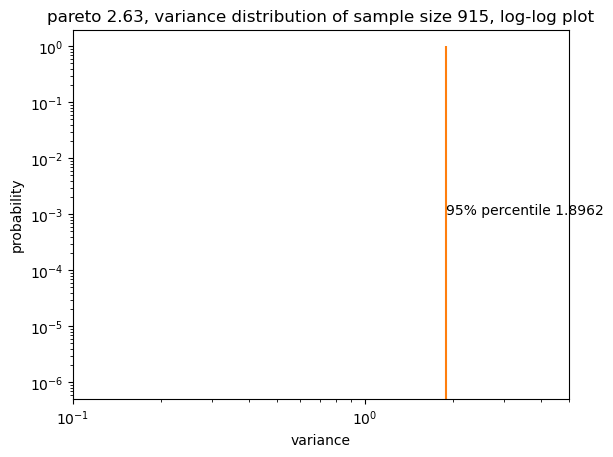

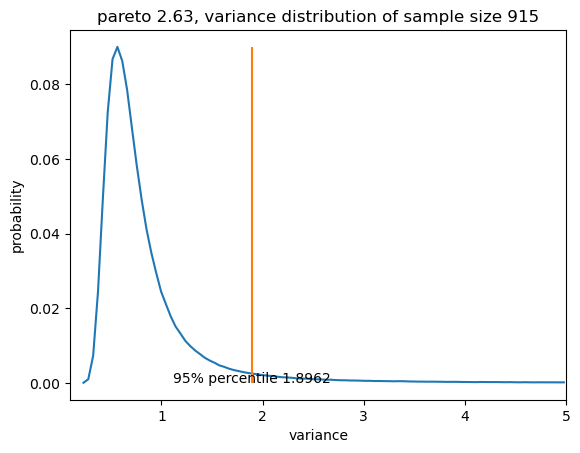

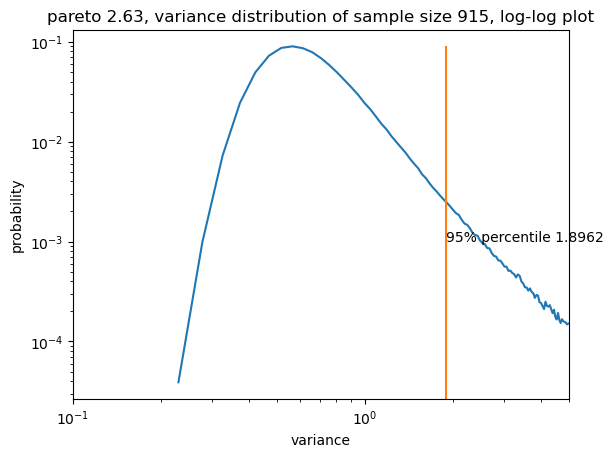

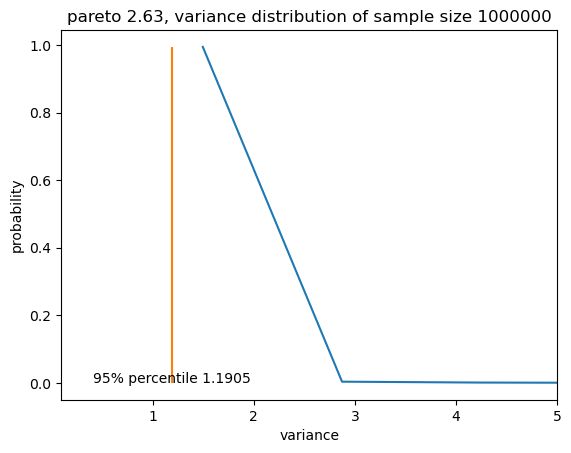

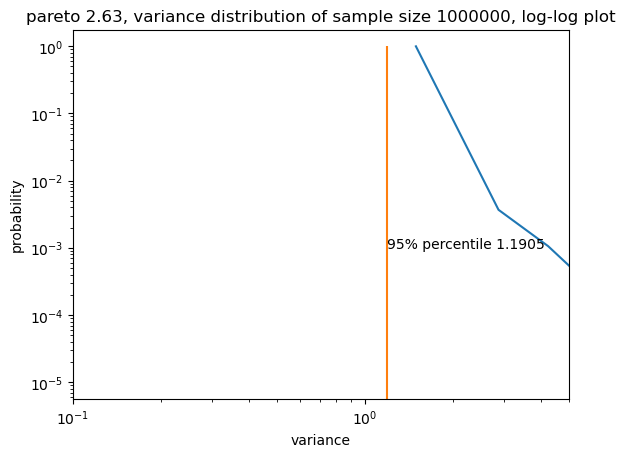

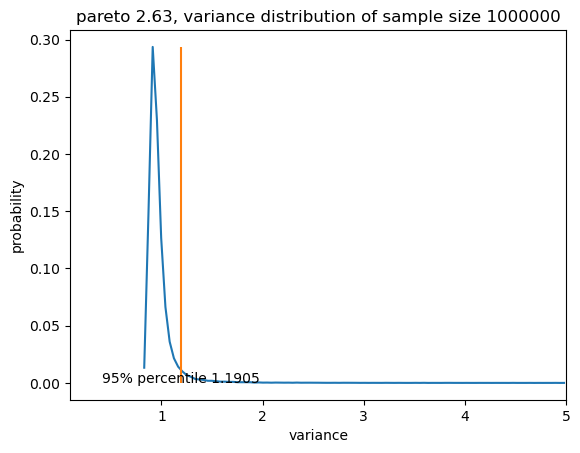

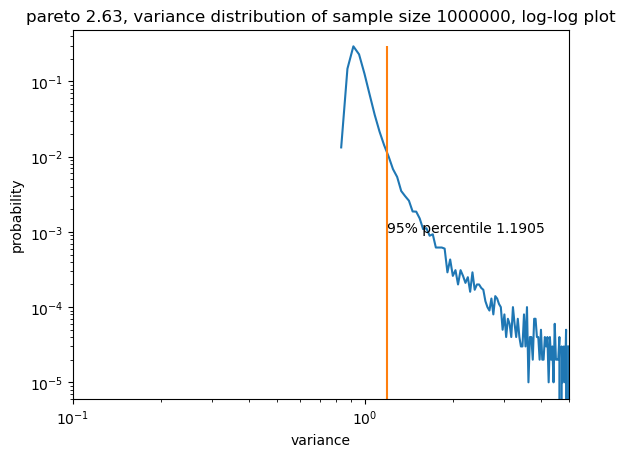

In [17]:
def paretoWithVariance(alpha):
    scale = np.sqrt((alpha-1)*(alpha-1)*(alpha-2)/alpha)
    distribution = scipy.stats.pareto(alpha, scale=scale)
    return distribution


class PDF:
    def __init__(self, x, pdf):
        self.x = x
        self.pdf = pdf


def getPDF(data, bins):
    hist = np.histogram(data, bins=bins)
    x = (hist[1][:-1] + hist[1][1:])/2
    pdf = hist[0]/len(data)
    return PDF(x, pdf)


def varianceDistribution(analysis):
    runs = 10000
    size = int(analysis.mcSize / runs)
    variance = np.zeros((runs, size))
    for i in range(runs):
        data = np.reshape(analysis.distribution.rvs(analysis.sampleSize*size), (size, analysis.sampleSize))
        variance[i] = np.var(data, axis=1)
        if (i % (runs/100)) == 0:
            print("%s run %d" % (analysis.name, i))
    variance = np.reshape(variance, analysis.mcSize)
    
    pdfAll = getPDF(variance, analysis.bins)

    # Zoom into our expected area for the chi-square distribution.
    subset = variance[variance<5]
    pdf02 = getPDF(subset, analysis.bins)
    pdf02.pdf *= len(subset) / len(variance)

    print(analysis.upperSignificance)
    upper = np.percentile(variance, analysis.upperSignificance)
    
    return ((pdfAll, pdf02), upper)


def analyze(analysis):
    print("%s variance: %f"%(analysis.name, analysis.distribution.var()))
    
    pdfs, upper = varianceDistribution(analysis)

    for pdf in pdfs:
        fig, ax = plt.subplots(1, 1)
        ax.plot(pdf.x, pdf.pdf)
        ax.vlines(upper, 0, np.max(pdf.pdf), color="C1")
        ax.text(upper, 0, "%d%% percentile %.4f"%(analysis.upperSignificance, upper), horizontalalignment="center")
        ax.set_xlim((1e-1, 5))
        ax.set_title("%s, variance distribution of sample size %d" % (analysis.name, analysis.sampleSize))
        ax.set_xlabel("variance")
        ax.set_ylabel("probability")
        
        fig, ax = plt.subplots(1, 1)
        ax.plot(pdf.x, pdf.pdf)
        ax.vlines(upper, 0, np.max(pdf.pdf), color="C1")
        ax.text(upper, 1e-3, "%d%% percentile %.4f"%(analysis.upperSignificance, upper))
        ax.set_xlim((1e-1, 5))
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_title("%s, variance distribution of sample size %d, log-log plot" % (analysis.name, analysis.sampleSize))
        ax.set_xlabel("variance")
        ax.set_ylabel("probability")


class Analysis:
    def __init__(self, name, sampleSize, bins, mcSize, distribution):
        self.name = name
        self.sampleSize = sampleSize
        self.bins = bins
        self.mcSize = int(bins*mcSize)
        self.distribution = distribution
        self.upperSignificance = 95


bins = 100
sampleSize = 915
analyze(Analysis("gaussian", sampleSize, bins, 1e4, scipy.stats.norm()))
alpha = 2.63
analyze(Analysis("pareto %.2f"%alpha, sampleSize, bins, 1e4, paretoWithVariance(alpha)))
analyze(Analysis("pareto %.2f"%alpha, 1000000, bins, 1e3, paretoWithVariance(alpha)))

22 0.43656949966168135 2.3650683116879923 5.417392450734184
30 0.3907653337513779 2.0129468855891677 5.151293402269642


Text(0, 0.5, 'skewness')

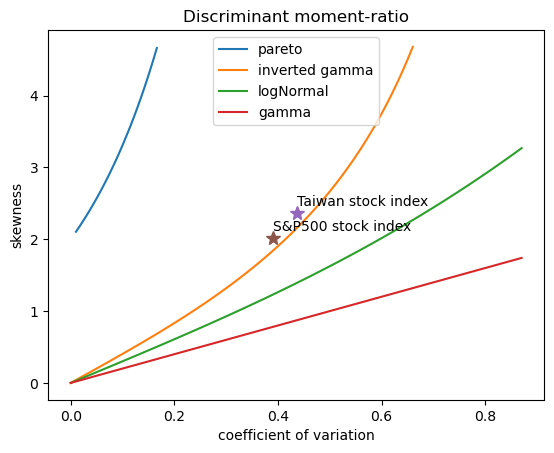

In [3]:
class Analysis:
    def __init__(self):
        self.name = ""
        self.fpath = ""

        self.lag = 1
        self.tailCutoff = 0.001

        self.n = 0
        self.cv = 0
        self.skew = 0
        

def paretoCurve(maxX, maxY):
    p = np.concatenate([
        np.arange(3.01, 5, 0.01),
        np.arange(5.1, 10, 0.1),
        np.arange(10, 100, 1),
        ])
    x = 1/np.sqrt(p*(p-2))
    y = (1+p)/(p-3)*2/np.sqrt(1-2/p)

    points = []
    for i in range(len(x)):
        xi = x[i]
        yi = y[i]

        if xi < maxX and yi < maxY:
            points.append([xi, yi])
    
    return np.array(points)


def invertedGammaCurve(maxX, maxY):
    gMaxX = min(1, maxX)
    n = 100
    
    x = np.arange(0, gMaxX-1/n, 1/n)
    y = 4*x/(1-x*x)

    points = []
    for i in range(len(x)):
        xi = x[i]
        yi = y[i]

        if xi < maxX and yi < maxY:
            points.append([xi, yi])
    
    return np.array(points)


def logNormalCurve(maxX, maxY):
    n = 100
    
    x = np.arange(0, maxX, 1/n)
    w = x*x + 1
    y = (w+2)*np.sqrt(w-1)

    points = []
    for i in range(len(x)):
        xi = x[i]
        yi = y[i]

        if xi < maxX and yi < maxY:
            points.append([xi, yi])
    
    return np.array(points)


def gammaCurve(maxX, maxY):
    n = 100
    
    x = np.arange(0, maxX, 1/n)
    y = 2*x

    points = []
    for i in range(len(x)):
        xi = x[i]
        yi = y[i]

        if xi < maxX and yi < maxY:
            points.append([xi, yi])
    
    return np.array(points)


def plotMomentRatio(ax, cv, skew):
    maxX = 2 * cv
    maxY = 2 * skew
    x = np.arange(0, maxX, maxX/100)
    
    pareto = paretoCurve(maxX, maxY)
    invertedGamma = invertedGammaCurve(maxX, maxY)
    logNormal = logNormalCurve(maxX, maxY)
    gamma = gammaCurve(maxX, maxY)

    ax.plot(pareto[:, 0], pareto[:, 1], label="pareto")
    ax.plot(invertedGamma[:, 0], invertedGamma[:, 1], label="inverted gamma")
    ax.plot(logNormal[:, 0], logNormal[:, 1], label="logNormal")
    ax.plot(gamma[:, 0], gamma[:, 1], label="gamma")


def analyzeMomentRatio(analysis):
    df = pandas.read_csv(analysis.fpath, dtype={'price': np.float64})
    
    df = df.iloc[::analysis.lag, :]
    df["returns"] = np.log(df.price / df.price.shift(-1))
    df.drop(df.tail(1).index,inplace=True)

    df["absreturn"] = df.returns.apply(lambda x: np.abs(x))
    df = df[df.returns < 0]
    df = df[(df.absreturn > analysis.lag*analysis.tailCutoff)]

    analysis.n = len(df)
    analysis.cv = np.std(df.absreturn) / np.mean(df.absreturn)
    analysis.skew = scipy.stats.skew(df.absreturn)

    print(analysis.n, analysis.cv, analysis.skew, analysis.skew/analysis.cv)


ans = []

analysis = Analysis()
analysis.name = "Taiwan stock index"
analysis.fpath = "taiex.csv"
analysis.lag = 50
analysis.tailCutoff = 0.003
analyzeMomentRatio(analysis)
ans.append(analysis)

analysis = Analysis()
analysis.name = "S&P500 stock index"
analysis.fpath = "sp500.csv"
analysis.lag = 50
analysis.tailCutoff = 0.0015
analyzeMomentRatio(analysis)
ans.append(analysis)

fig, ax = plt.subplots(1, 1)
plotMomentRatio(ax, np.max([a.cv for a in ans]), np.max([a.skew for a in ans]))
for analysis in ans:
    ax.plot(analysis.cv, analysis.skew, "*", markersize=10)
    ax.text(analysis.cv, analysis.skew+0.1, analysis.name)
ax.legend(loc="upper center")
ax.set_title("Discriminant moment-ratio")
ax.set_xlabel("coefficient of variation")
ax.set_ylabel("skewness")

/tmp/ipykernel_276779/760716220.py:17: RuntimeWarning: invalid value encountered in scalar divide
  eu = np.sum(larger-u) / len(larger)
/tmp/ipykernel_276779/760716220.py:17: RuntimeWarning: invalid value encountered in scalar divide
  eu = np.sum(larger-u) / len(larger)


131 131
74 74


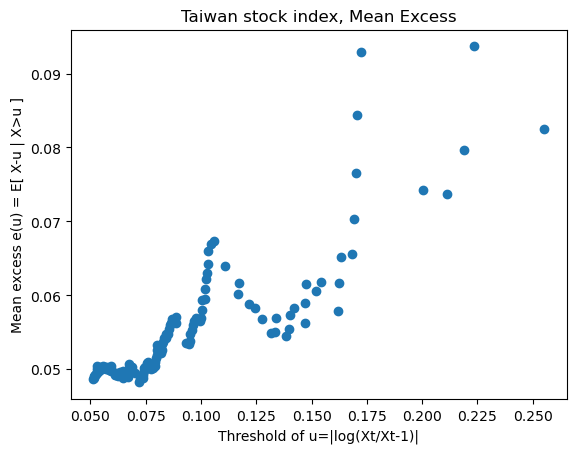

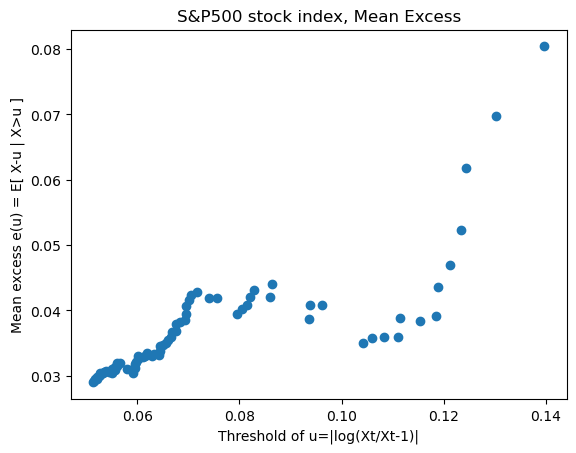

In [2]:
def analyzeME(analysis):
    df = pandas.read_csv(analysis.fpath, dtype={'price': np.float64})
    
    df = df.iloc[::analysis.lag, :]
    df["returns"] = np.log(df.price / df.price.shift(-1))
    df.drop(df.tail(1).index,inplace=True)

    df["absreturn"] = df.returns.apply(lambda x: np.abs(x))
    df = df[df.returns < 0]
    df = df[(df.absreturn > analysis.lag*analysis.tailCutoff)]

    orderedStats = np.sort(df.absreturn)
    excess = []
    for i in range(len(orderedStats)):
        u = orderedStats[i]
        larger = orderedStats[i+1:]
        eu = np.sum(larger-u) / len(larger)
        excess.append(eu)

    lastRemoveN = 3
    u = orderedStats[:len(orderedStats)-lastRemoveN]
    eu = np.array(excess)[:len(excess)-lastRemoveN]
    print(len(u), len(eu))

    fig, ax = plt.subplots(1, 1)
    ax.plot(u, eu, "o")
    ax.set_title("%s, Mean Excess"%(analysis.name))
    ax.set_xlabel("Threshold of u=|log(Xt/Xt-1)|")
    ax.set_ylabel("Mean excess e(u) = E[ X-u | X>u ]")


analysis = Analysis()
analysis.name = "Taiwan stock index"
analysis.fpath = "taiex.csv"
analysis.lag = 17
analysis.tailCutoff = 0.003
analyzeME(analysis)

analysis = Analysis()
analysis.name = "S&P500 stock index"
analysis.fpath = "sp500.csv"
analysis.lag = 17
analysis.tailCutoff = 0.003
analyzeME(analysis)

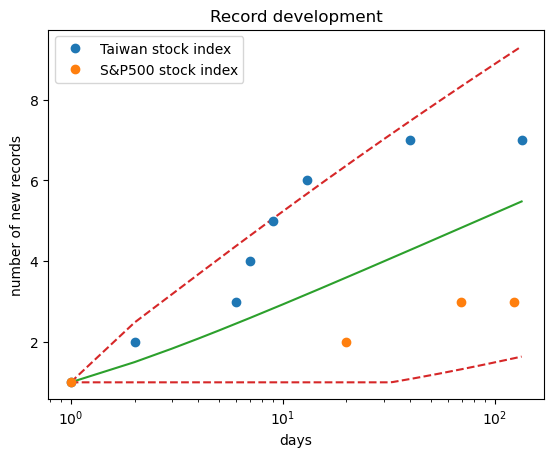

In [27]:
class Analysis:
    def __init__(self):
        self.name = ""
        self.fpath = ""

        self.lag = 1
        self.tailCutoff = 0.001
        self.positive = True


def getData(analysis):
    df = pandas.read_csv(analysis.fpath, dtype={'price': np.float64})
    
    df = df.iloc[::analysis.lag, :]
    df["returns"] = np.log(df.price / df.price.shift(-1))
    df.drop(df.tail(1).index,inplace=True)

    df["absreturn"] = df.returns.apply(lambda x: np.abs(x))
    if analysis.positive:
        df = df[df.returns > 0]
    else:
        df = df[df.returns < 0]
    df = df[(df.absreturn > analysis.lag*analysis.tailCutoff)]

    df["date"] = pandas.to_datetime(df.date)
    df = df.sort_values(by='date', ascending=True)

    return df


def recordInterval(n, ci):
    res = []
    mean = 0
    var = 0
    for i in range(int(n)):
        i1 = i + 1
        
        mean += 1/i1
        var += (1/i1 - 1/i1/i1)
        res.append((i1, mean, np.max([1, mean-ci*np.sqrt(var)]), mean+ci*np.sqrt(var)))
    return pandas.DataFrame(np.array(res), columns=("n", "mu", "ll", "ul"))


def analyzeRecord(analysis):
    df = getData(analysis)

    firstDt = df.iloc[0].date.timestamp()
    mx = -sys.float_info.max
    numRecord = 0
    records = []
    for i in range(len(df)):
        dt = df.iloc[i].date.timestamp()
        days = (dt - firstDt)/86400
        v = df.iloc[i].absreturn

        got = False
        if v > mx:
            mx = v
            numRecord += 1
            got = True

        if got or (i == len(df)-1):
            rc = [i+1, days+1, dt, v, numRecord]
            records.append(rc)
            
    records = pandas.DataFrame(np.array(records), columns=("i", "days", "date", "v", "numRecord"))
    records["date"] = records.date.astype("datetime64[s]")
    return records


def analyzeRecordList(ass):
    records = []
    for analysis in ass:
        rcs = analyzeRecord(analysis)
        records.append(rcs)

    metric = "i"
    maxX = np.max([np.max(rcs[metric]) for rcs in records])
    ci = 1.96
    # ci = 3
    theory = recordInterval(maxX, ci)
    
    fig, ax = plt.subplots(1, 1)
    ax.plot(theory.n.to_numpy(), theory.mu.to_numpy(), color="C%d"%len(records))
    ax.plot(theory.n.to_numpy(), theory.ll.to_numpy(), "--", color="C%d"%(len(records)+1))
    ax.plot(theory.n.to_numpy(), theory.ul.to_numpy(), "--", color="C%d"%(len(records)+1))
    for i, rcs in enumerate(records):
        analysis = ass[i]
        positive = "positive"
        if not analysis.positive:
            positive = "negative"
        ax.plot(rcs[metric].to_numpy(), rcs.numRecord.to_numpy(), "o", label="%s"%(analysis.name,))
    ax.legend()
    ax.set_xscale("log")
    ax.set_title("Record development")
    ax.set_xlabel("days")
    ax.set_ylabel("number of new records")


ass = []
lag = 17
for isPositive in (False,):
    analysis = Analysis()
    analysis.name = "Taiwan stock index"
    analysis.fpath = "taiex.csv"
    analysis.lag = lag
    analysis.tailCutoff = 0.003
    analysis.positive = isPositive
    ass.append(analysis)
    
    analysis = Analysis()
    analysis.name = "S&P500 stock index"
    analysis.fpath = "sp500.csv"
    analysis.lag = lag
    analysis.tailCutoff = 0.002
    analysis.positive = isPositive
    ass.append(analysis)

analyzeRecordList(ass)

17 0.003
17 0.003


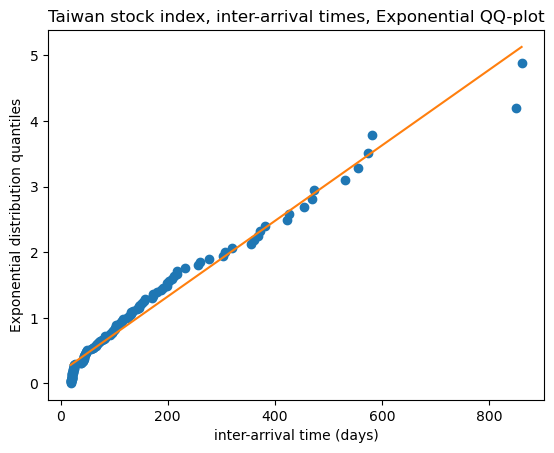

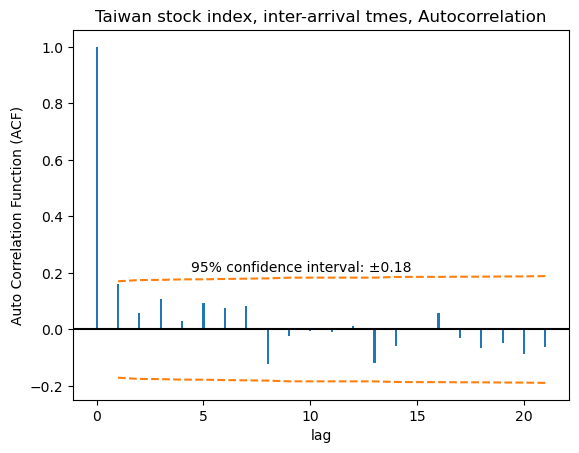

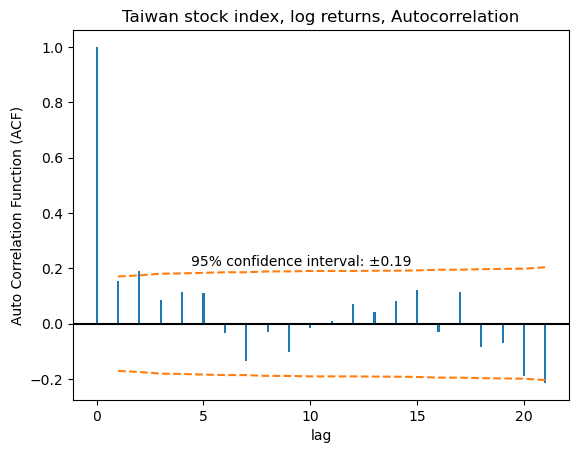

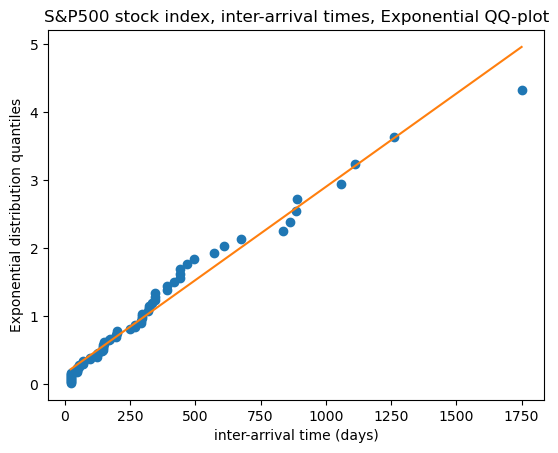

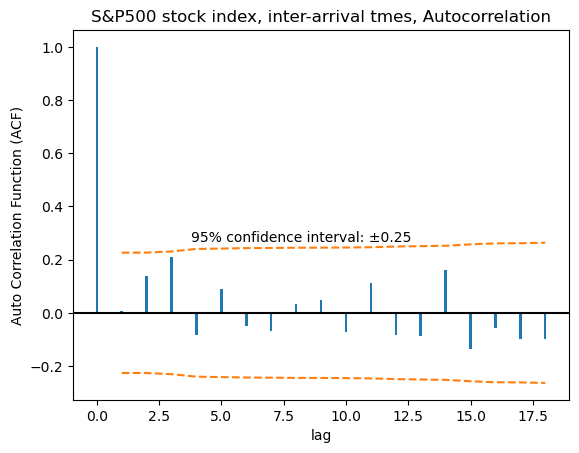

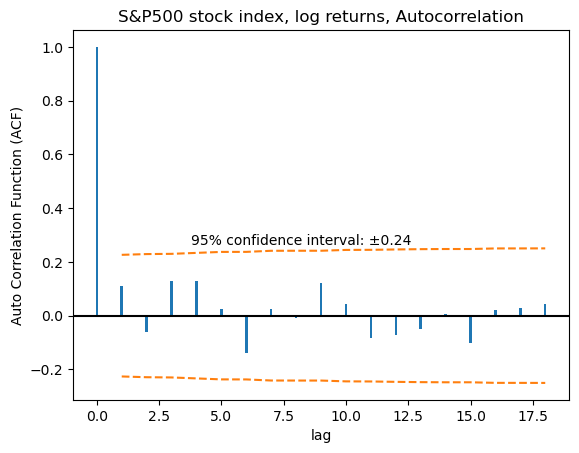

In [3]:
class Analysis:
    def __init__(self):
        self.name = ""
        self.fpath = ""

        self.lag = 1
        self.tailCutoff = 0.001


def getData(analysis):
    df = pandas.read_csv(analysis.fpath, dtype={'price': np.float64})
    
    df = df.iloc[::analysis.lag, :]
    df["returns"] = np.log(df.price / df.price.shift(-1))
    df.drop(df.tail(1).index,inplace=True)

    df["absreturn"] = df.returns.apply(lambda x: np.abs(x))
    df = df[df.returns < 0]
    df = df[(df.absreturn > analysis.lag*analysis.tailCutoff)]

    df["date"] = pandas.to_datetime(df.date)
    df = df.sort_values(by='date', ascending=True)

    return df


def analyzeArrival(analysis, df):
    # Compute inter-arrival times
    df["days"] = (df.date - df.date.shift(1)).dt.days
    df = df.iloc[1:]

    # Compute quantiles
    df = df.sort_values(by="days", ascending=True)
    df["q"] = df.days.rank(pct=True, method="average")
    df["q"] = (np.arange(len(df))+1)/len(df)
    df = df.iloc[:-1]

    # Compute theory
    df["exponential"] = scipy.stats.expon(scale=1).ppf(df.q)
    linres = scipy.stats.linregress(df.days, df.exponential)
    df["exponLin"] = linres.intercept + linres.slope*df.days

    return df


def analyzeArrivalTime(ass):
    records = []
    for analysis in ass:
        print(analysis.lag, analysis.tailCutoff)
        df = getData(analysis)
        if len(df) < 10:
            continue
        rcs = analyzeArrival(analysis, df)
        records.append(rcs)

    for i, rcs in enumerate(records):
        # with pandas.option_context('display.max_rows', None):
        #     print(rcs.iloc[200:])
        fig, ax = plt.subplots(1, 1)
        analysis = ass[i]
        positive = "positive"
        if not analysis.positive:
            positive = "negative"
        ax.plot(rcs.days.to_numpy(), rcs.exponential.to_numpy(), "o", label="%s"%(analysis.name,))
        ax.plot(rcs.days.to_numpy(), rcs.exponLin.to_numpy())
        #ax.legend()
        #ax.set_xscale("log")
        ax.set_title("%s, inter-arrival times, Exponential QQ-plot"%(analysis.name,))
        ax.set_xlabel("inter-arrival time (days)")
        ax.set_ylabel("Exponential distribution quantiles")

        quantities = [{"name": "inter-arrival tmes", "col": "days"}, {"name": "log returns", "col": "absreturn"}]
        for q in quantities:
            vs = rcs.sort_values(by='date', ascending=True)[q["col"]]
            
            acs1 = [vs.autocorr(i) for i in range(int(10*np.log10(len(vs))))]
            confidence = 95
            interval1 = scipy.stats.norm.ppf(1 - (1-confidence/100.0) / 2.0) * np.sqrt(1/len(vs)) * np.ones(len(acs1))
            
            acs2, confint, qstat, pvals = statsmodels.tsa.stattools.acf(vs, alpha=1-confidence/100.0, qstat=True, fft=True)
            #print(acs2, confint, qstat, pvals)
            interval2 = (confint[1:, 1] - confint[1:, 0])/2
            

            fig, ax = plt.subplots(1, 1)
            #ax.axhline(interval, linestyle="--", color="C1")
            #ax.axhline(-interval, linestyle="--", color="C1")
            ax.plot(np.arange(1, len(acs2), 1), interval2, linestyle="--", color="C1")
            ax.plot(np.arange(1, len(acs2), 1), -interval2, linestyle="--", color="C1")
            #ax.plot(np.arange(0, len(acs1), 1), acs1, "o")
            ax.axhline(0, linestyle="-", color="black")
            ax.bar(np.arange(0, len(acs2), 1), acs2, width=0.1)
            itv = interval2[int(len(interval2)/2)]
            ax.text(len(acs2)/5, itv+0.02, ("%d%% confidence interval: ±%.2f"%(confidence, itv)))
            ax.set_title("%s, %s, Autocorrelation"%(analysis.name, q["name"]))
            ax.set_xlabel("lag")
            ax.set_ylabel("Auto Correlation Function (ACF)")


ass = []
lag = 17
for tailCutoff in [0.003]:
    for isPositive in (False,):
        analysis = Analysis()
        analysis.name = "Taiwan stock index"
        analysis.fpath = "taiex.csv"
        analysis.lag = lag
        analysis.tailCutoff = tailCutoff
        analysis.positive = isPositive
        ass.append(analysis)
        
        analysis = Analysis()
        analysis.name = "S&P500 stock index"
        analysis.fpath = "sp500.csv"
        analysis.lag = lag
        analysis.tailCutoff = tailCutoff
        analysis.positive = isPositive
        ass.append(analysis)
    
analyzeArrivalTime(ass)